# HIVE: converting ABF to HDF5

First, we'll convert the ABF file to HDF5

In [60]:
from pathlib import Path
from hive.convert.abf2h5 import ABFConverter


input_file = '/data/hnl/in-vitro/incoming/2019_05_15_NE_uncorrelated_100k_97Hz_CFR001+CFR002/2019_05_15_NE_uncorrelated_100k_97Hz_CFR001+CFR002_0000.abf'
output_file = '/tmp/test.h5'

abf = ABFConverter(
    input_file=input_file,
    output_file=output_file,
    channel_select=[0, 1],
    verbose=True)

abf.process()

read 2019_05_15_NE_uncorrelated_100k_97Hz_CFR001+CFR002_0000.abf: 0.451644 seconds
	wrote header: 0.005958 seconds
	wrote data: 2.489865 seconds
wrote test.h5: 2.609739 seconds


Let's look at the HDF file

In [61]:
import h5py

with h5py.File(output_file) as h5:
    print(h5['data'])
    for i in h5['header'].attrs.items():
        print(i)
    print(h5['header/sweepTimes'])
    print(h5['header/sweepStartInPts'])

<HDF5 dataset "data": shape (1032, 2, 10000), type "<f8">
('abfTimestamp', 1557950384.951)
('recChNames', array(['FSCV_1', 'Cmd_1'], dtype=object))
('recTime', array([57584.951, 57688.151]))
('sampleFreq', 100000)
('si', 10.000000000000002)
('sweepCount', 10000)
('sweepFreq', 96.89922480620154)
('sweepSampleCount', 1032)
<HDF5 dataset "sweepTimes": shape (10000,), type "<f8">
<HDF5 dataset "sweepStartInPts": shape (10000,), type "<f8">


(1032, 2, 10000)
(1032, 2, 10000)


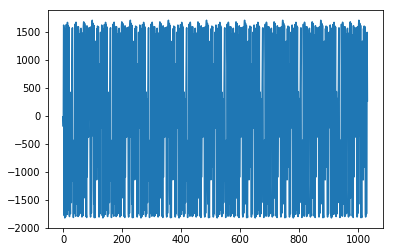

In [64]:
import matplotlib.pyplot as plt
import numpy as np

with h5py.File(output_file) as h5:
    data = h5['data']
    print(data.shape)
    data = np.array(data)
    print(data.shape)
    plt.plot(data[:, 0, 5000])



Let's take a look at the ABF file

In [45]:
import pyabf

abf = pyabf.ABF(input_file)

In [55]:
from datetime import datetime, time
import numpy as np

channels_to_convert = [0, 1, 2, 3]

# now, we can read in the data
sweep_count = abf.sweepCount
sweep_samples = abf.sweepPointCount
sample_freq = abf.dataRate
sweep_freq = sample_freq / sweep_samples
sweep_times = abf.sweepTimesSec
abf_timestamp = abf.abfDateTime.timestamp()

#
# required header fields for compatibility with Matlab's abfload()
#

# recTime: recording start and stop time in seconds from
# midnight (millisecond resolution)
_start_sec = (
    abf.abfDateTime -
    datetime.combine(
        abf.abfDateTime.date(),
        time(0, 0, 0))
).total_seconds()
_end_sec = _start_sec + (sweep_count / sweep_freq)
rec_time = [_start_sec, _end_sec]

# si: sampling interval
si = round(1 / sample_freq / 1e-6, 6)

# recChNames: the names of all channels, e.g. 'IN 8',...
recChNames = [abf.adcNames[i] for i in channels_to_convert]

# sweepStartInPts: the start times of sweeps in sample points
# (from beginning of recording)
sweepStartInPts = abf.sweepTimesSec * abf.dataRate

In [57]:
channels_to_convert = [0, 1]

data = np.zeros(shape = (
    sweep_samples, 
    len(channels_to_convert), 
    sweep_count))

for ix, c in enumerate(channels_to_convert):
    data[:, ix, :] = abf.data[c].reshape(
        sweep_count, 
        sweep_samples).T

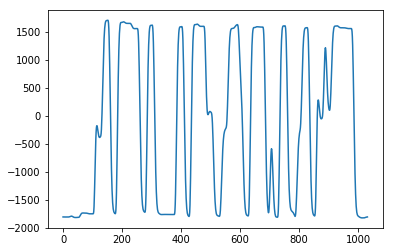

In [58]:
import matplotlib.pyplot as plt

_ = plt.plot(data[:, 0, 5000])
